In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from sklearn.preprocessing import LabelEncoder
import time
%matplotlib inline

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm

import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

/Users/caoyuxin/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available


In [2]:
## Load the dateset
TRAIN_DIR = './FER2013/train/'
TEST_DIR = './FER2013/test/'

In [3]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(    
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.3,
)

validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all train images
train_generator = train_data_gen.flow_from_directory(
        TRAIN_DIR,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

# Preprocess all validation images
validation_generator = validation_data_gen.flow_from_directory(
        TEST_DIR,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# train_X = np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
# train_Y = np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])
# val_X = np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
# val_Y = np.concatenate([validation_generator.next()[1] for i in range(validation_generator.__len__())])

In [5]:
train_X = np.empty([28709, 48, 48, 1])
train_Y = np.empty([28709, 7])
start = 0
end = 0
for i in range(0, 449):
    image, label = train_generator.next()
    end = end + image.shape[0]
    train_X[start:end, :, :, :] = image
    train_Y[start:end, :] = label
    start = start + image.shape[0]

In [6]:
val_X = np.empty([7178, 48, 48, 1])
val_Y = np.empty([7178, 7])
start = 0
end = 0
for i in range(0, 113):
    image, label = validation_generator.next()
    end = end + image.shape[0]
    val_X[start:end, :, :, :] = image
    val_Y[start:end, :] = label
    start = start + image.shape[0]

## DCNN: Architecture 1

In [7]:
# create model structure
dcnn_model1 = Sequential([
    #C1 + P1
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    #C2 + P2
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    #C3 + P3
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    #Dropout(0.2),
    
    #FC1
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    
    #FC2
    Dense(128, activation='relu'),   
    Dropout(0.2),
    
    #FC3
    Dense(7, activation='softmax')
])

dcnn_model1.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001,epsilon=1e-06),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

dcnn_model1.summary()

# Train the neural network/model
dcnn_model1_info = dcnn_model1.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=60,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 32)        9248      
                          

2022-12-07 22:10:55.727776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-07 22:10:55.727893: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/60


2022-12-07 22:10:55.952597: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-07 22:10:56.286109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


446/448 [============================>.] - ETA: 0s - loss: 1.8295 - accuracy: 0.2453

2022-12-07 22:11:06.833552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - 12s 26ms/step - loss: 1.8297 - accuracy: 0.2452 - val_loss: 1.8167 - val_accuracy: 0.2506
Epoch 2/60
448/448 [==============================] - 12s 26ms/step - loss: 1.7901 - accuracy: 0.2530 - val_loss: 1.7700 - val_accuracy: 0.2660
Epoch 3/60
448/448 [==============================] - 12s 26ms/step - loss: 1.7585 - accuracy: 0.2737 - val_loss: 1.7139 - val_accuracy: 0.3150
Epoch 4/60
448/448 [==============================] - 11s 25ms/step - loss: 1.6970 - accuracy: 0.3211 - val_loss: 1.6225 - val_accuracy: 0.3723
Epoch 5/60
448/448 [==============================] - 12s 26ms/step - loss: 1.6556 - accuracy: 0.3425 - val_loss: 1.5782 - val_accuracy: 0.3767
Epoch 6/60
448/448 [==============================] - 12s 26ms/step - loss: 1.6228 - accuracy: 0.3608 - val_loss: 1.5463 - val_accuracy: 0.3947
Epoch 7/60
448/448 [==============================] - 11s 25ms/step - loss: 1.5962 - accuracy: 0.3757 - val_loss: 1.5190 - val_accuracy: 0.4141
Epo

448/448 [==============================] - 11s 25ms/step - loss: 1.1350 - accuracy: 0.5683 - val_loss: 1.1704 - val_accuracy: 0.5635
Epoch 58/60
448/448 [==============================] - 11s 24ms/step - loss: 1.1352 - accuracy: 0.5705 - val_loss: 1.1549 - val_accuracy: 0.5638
Epoch 59/60
448/448 [==============================] - 11s 24ms/step - loss: 1.1291 - accuracy: 0.5723 - val_loss: 1.1527 - val_accuracy: 0.5693
Epoch 60/60
448/448 [==============================] - 11s 24ms/step - loss: 1.1170 - accuracy: 0.5760 - val_loss: 1.1454 - val_accuracy: 0.5699


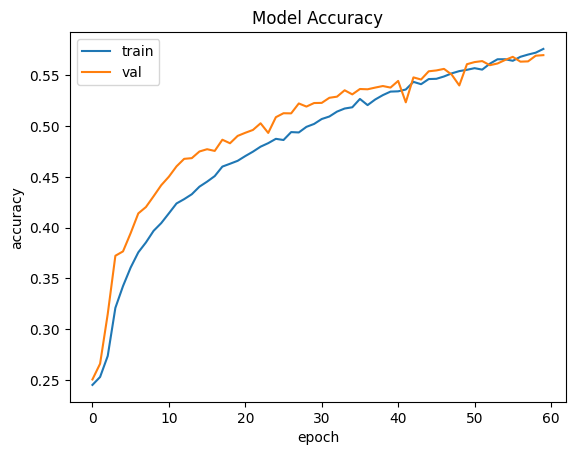

In [8]:
# plot accuracy
plt.plot(dcnn_model1_info.history['accuracy'])
plt.plot(dcnn_model1_info.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

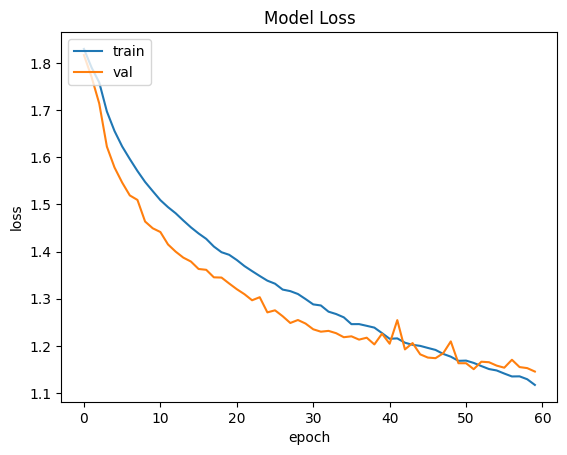

In [9]:
# plot loss
plt.plot(dcnn_model1_info.history['loss'])
plt.plot(dcnn_model1_info.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
dcnn_model1.evaluate(val_X, val_Y, verbose = 2)

225/225 - 2s - loss: 1.1463 - accuracy: 0.5697 - 2s/epoch - 7ms/step


[1.1462926864624023, 0.5696573257446289]

In [10]:
dcnn_model1.save('my_dcnn_model1.h5')

## DCNN: Architecture 2

In [11]:
# create model structure
dcnn_model2 = Sequential([
    #C1 + P1
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same", input_shape=(48, 48, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    #C2 + P2
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    #C3 + P3
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    #C4 + P4
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    #FC1
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    
    #FC2
    Dense(128, activation='relu'),   
    Dropout(0.2),
    
    #FC3
    Dense(7, activation='softmax')
])

dcnn_model2.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001,epsilon=1e-06),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

dcnn_model2.summary()

# Train the neural network/model
dcnn_model2_info = dcnn_model2.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=60,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        9248      
                                                      

2022-12-07 22:22:15.231689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


447/448 [============================>.] - ETA: 0s - loss: 1.8283 - accuracy: 0.2450

2022-12-07 22:22:28.450876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - 15s 32ms/step - loss: 1.8283 - accuracy: 0.2447 - val_loss: 1.8047 - val_accuracy: 0.2472
Epoch 2/60
448/448 [==============================] - 14s 32ms/step - loss: 1.7699 - accuracy: 0.2715 - val_loss: 1.7160 - val_accuracy: 0.3152
Epoch 3/60
448/448 [==============================] - 14s 32ms/step - loss: 1.7137 - accuracy: 0.3158 - val_loss: 1.6475 - val_accuracy: 0.3608
Epoch 4/60
448/448 [==============================] - 14s 32ms/step - loss: 1.6560 - accuracy: 0.3473 - val_loss: 1.5733 - val_accuracy: 0.3901
Epoch 5/60
448/448 [==============================] - 14s 32ms/step - loss: 1.6065 - accuracy: 0.3713 - val_loss: 1.5439 - val_accuracy: 0.4035
Epoch 6/60
448/448 [==============================] - 14s 32ms/step - loss: 1.5734 - accuracy: 0.3848 - val_loss: 1.5095 - val_accuracy: 0.4088
Epoch 7/60
448/448 [==============================] - 14s 32ms/step - loss: 1.5382 - accuracy: 0.4030 - val_loss: 1.4575 - val_accuracy: 0.4340
Epo

448/448 [==============================] - 16s 35ms/step - loss: 0.9666 - accuracy: 0.6399 - val_loss: 1.0870 - val_accuracy: 0.5986
Epoch 58/60
448/448 [==============================] - 15s 33ms/step - loss: 0.9680 - accuracy: 0.6385 - val_loss: 1.1043 - val_accuracy: 0.5939
Epoch 59/60
448/448 [==============================] - 15s 34ms/step - loss: 0.9479 - accuracy: 0.6437 - val_loss: 1.0812 - val_accuracy: 0.6066
Epoch 60/60
448/448 [==============================] - 15s 33ms/step - loss: 0.9398 - accuracy: 0.6469 - val_loss: 1.0942 - val_accuracy: 0.5967


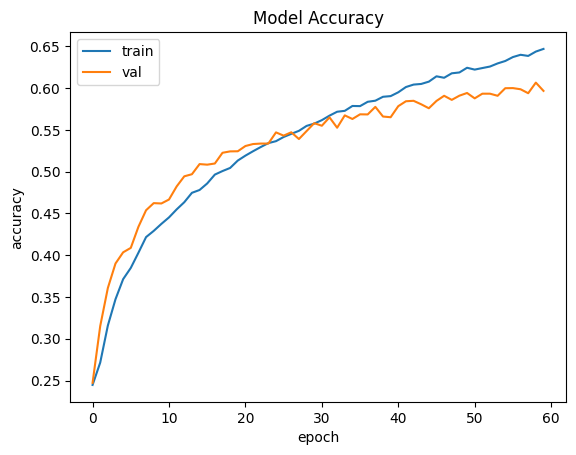

In [12]:
# plot accuracy
plt.plot(dcnn_model2_info.history['accuracy'])
plt.plot(dcnn_model2_info.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

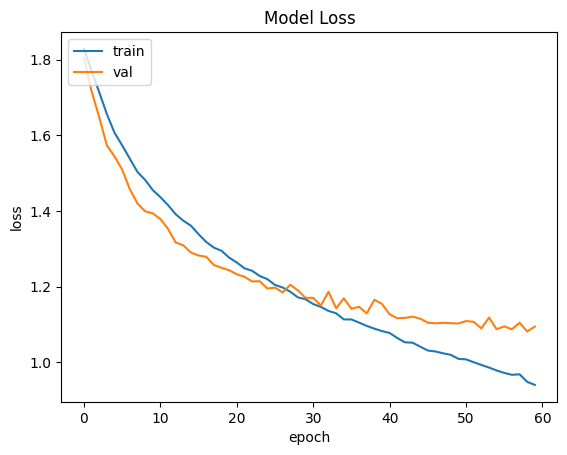

In [13]:
# plot loss
plt.plot(dcnn_model2_info.history['loss'])
plt.plot(dcnn_model2_info.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
dcnn_model2.evaluate(val_X, val_Y, verbose = 2)

225/225 - 2s - loss: 1.0938 - accuracy: 0.5965 - 2s/epoch - 10ms/step


[1.0938202142715454, 0.5965450406074524]

In [14]:
dcnn_model2.save('my_dcnn_model2.h5')

## DCNN: Architecture 3

In [15]:
# create model structure
dcnn_model3 = Sequential([
    #C1 + P1
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same", input_shape=(48, 48, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    #C2 + P2
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    #C3 + P3
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    #C4 + P4
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    #C5 + P5
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    #FC1
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    
    #FC2
    Dense(128, activation='relu'),   
    Dropout(0.2),
    
    #FC3
    Dense(7, activation='softmax')
])

dcnn_model3.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001,epsilon=1e-06),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

dcnn_model3.summary()

# Train the neural network/model
dcnn_model3_info = dcnn_model3.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=60,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_15 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 32)        9248      
                                                      

2022-12-07 22:37:00.078047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - ETA: 0s - loss: 1.8344 - accuracy: 0.2431

2022-12-07 22:37:13.583472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - 15s 33ms/step - loss: 1.8344 - accuracy: 0.2431 - val_loss: 1.8236 - val_accuracy: 0.2468
Epoch 2/60
448/448 [==============================] - 15s 32ms/step - loss: 1.8124 - accuracy: 0.2492 - val_loss: 1.7854 - val_accuracy: 0.2478
Epoch 3/60
448/448 [==============================] - 15s 32ms/step - loss: 1.7482 - accuracy: 0.2905 - val_loss: 1.6693 - val_accuracy: 0.3361
Epoch 4/60
448/448 [==============================] - 15s 32ms/step - loss: 1.6799 - accuracy: 0.3319 - val_loss: 1.6017 - val_accuracy: 0.3719
Epoch 5/60
448/448 [==============================] - 15s 33ms/step - loss: 1.6360 - accuracy: 0.3551 - val_loss: 1.5634 - val_accuracy: 0.3898
Epoch 6/60
448/448 [==============================] - 14s 32ms/step - loss: 1.6002 - accuracy: 0.3729 - val_loss: 1.5169 - val_accuracy: 0.3994
Epoch 7/60
448/448 [==============================] - 14s 32ms/step - loss: 1.5612 - accuracy: 0.3923 - val_loss: 1.4699 - val_accuracy: 0.4339
Epo

448/448 [==============================] - 15s 34ms/step - loss: 1.0169 - accuracy: 0.6185 - val_loss: 1.1158 - val_accuracy: 0.5901
Epoch 58/60
448/448 [==============================] - 15s 33ms/step - loss: 1.0157 - accuracy: 0.6187 - val_loss: 1.1045 - val_accuracy: 0.5915
Epoch 59/60
448/448 [==============================] - 15s 33ms/step - loss: 1.0080 - accuracy: 0.6207 - val_loss: 1.1286 - val_accuracy: 0.5876
Epoch 60/60
448/448 [==============================] - 15s 33ms/step - loss: 1.0022 - accuracy: 0.6273 - val_loss: 1.0982 - val_accuracy: 0.5904


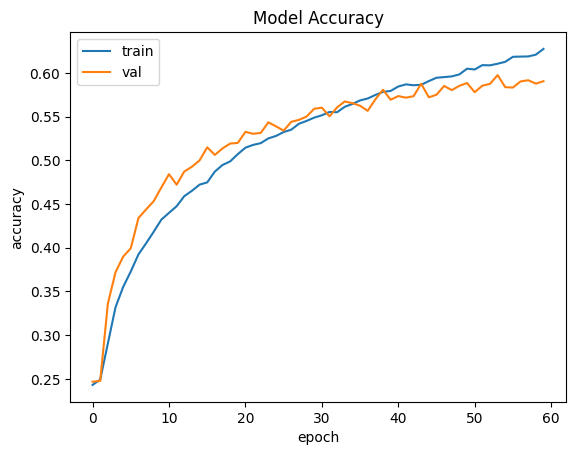

In [16]:
# plot accuracy
plt.plot(dcnn_model3_info.history['accuracy'])
plt.plot(dcnn_model3_info.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

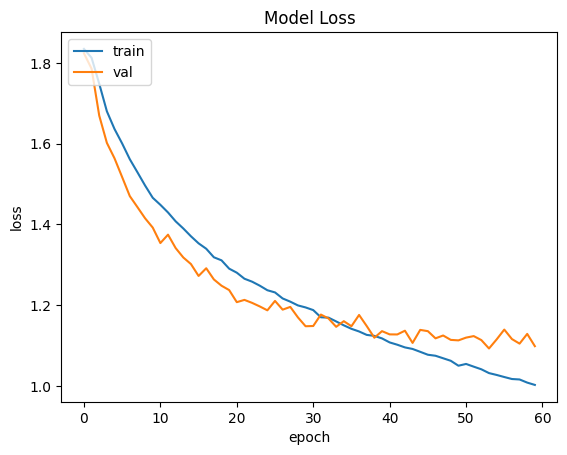

In [17]:
# plot loss
plt.plot(dcnn_model3_info.history['loss'])
plt.plot(dcnn_model3_info.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
dcnn_model3.evaluate(val_X, val_Y, verbose = 2)

225/225 - 2s - loss: 1.0975 - accuracy: 0.5906 - 2s/epoch - 9ms/step


[1.0975126028060913, 0.5905544757843018]

In [18]:
dcnn_model3.save('my_dcnn_model3.h5')